In [25]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import sympy
from scipy.linalg import expm
import scipy.constants as sc
from tqdm import tqdm_notebook
from scipy.fft import fft,ifft,fftfreq, dct, idct
from itertools import combinations
import pandas as pd
import seaborn as sns
from objsize import get_deep_size
from scipy import linalg
import datetime
import os
from scipy.sparse import csc_matrix
import matplotlib.ticker as ticker
import math


def parallelise_job(function,inputs,verbose = 1,backend = 'loky',n_jobs = -1):
    """
    Performs a parallelised task using joblib (which works in notebooks).
    """
    from joblib import Parallel, delayed
    return Parallel(n_jobs=n_jobs, verbose=verbose,backend = backend)(
                 map(delayed(function), inputs))

In [57]:
def para_projection(M_index):

        ##M_indices is the list of rows/columns of
        ##the whole space matrix representation that
        ##have the quantum number M

        ##A and B are matrices that have dimensions of 2^N by 2^N

        dim_M = np.size(M_indices)
        dim_A = A.shape[0]
        ##out is a matrix of zeros that has dimensions of the subspace.
        out = np.zeros(dim_M,dtype=np.complex64)
        m=0
        R_i = np.floor(M_index/dim_A)
        K_i = M_index -dim_A*R_i
        for j in M_indices:
            R_j = np.floor(j/dim_A)
            K_j = j -dim_A*R_j
            A_cross_B_ij = A[R_i,R_j]*B[K_i,K_j]
            out[m] = A_cross_B_ij
            m +=1
        return Qobj(out)
M_indices = method.M_indices
A = method.L
B = method.L
parallelise_job(para_projection,M_indices)

In [ ]:
class lindbladian_Louville_operator():
    def __init__(self,N,h,J,J_prime,delta,delta_prime,b,t,tau,nv,NH,M_choice,
                gamma0,gamma_L_plus,gamma_L_min,gamma_R_plus,gamma_R_min):
        
        for local in locals().copy(): 
            ## equivalent of writing self.gamma = gamma,self.b = b etc.
            ## without having to rewrite it.
            exec('self.' + local +  ' = locals()[local]')
        
        
        self.model_bool = int(input('Next-to-nearest-neighbour-Heisenberg XXZ Hamiltonian?'))
        self.model_choice = int(input('Which Model? Deph = 0, Heisenberg XXX = 1, non H XXX = 2, no specific model=3'))
        
        
        ###initialising variables so they don't have to called in 
        ###each function
        self.initialise_variables()
        print("Variables initialised,calculating the Louvillian.")
        ##calls function to create the Liouvillian
        self.L = self.L()
        print("Calculating P, the time evolution matrix.")
        ##calls function to create P and solve for the eigenenergies.
        self.P,self.evecs,self.evals = self.P()
        
        ##calls function to create z_k along with the degeneracy factor of each ratio
        self.deg_factor = np.unique(self.evals,return_counts=True)[-1]
        deg_bool = int(input('Remove degeneracy?'))
        if deg_bool:
            
            self.E_array,self.deg_factor = np.unique(self.evals,return_counts=True)
        else:   
            
            ##defining E_array for z_k_spec and for the parallelization
            self.E_array = self.evals#np.unique(self.evals)
        
        #self.z_k = parallelise_job(self.z_k_spec,self.E_array,verbose = False)
        self.z_k = self.z_k(self.E_array)
        
        
        
        ##choice of whether to save data
        self.save_boolean = bool(int(input('Save Data?')))
        self.add_to_average = int(input('Add to average?'))
        
        ##defines path for my computer
        self.path = 'C://Users/david/OneDrive/Documents/UNI/UCL project/data/'  
    
        ##retrieves the single number signatures of the data and prints them.
        self.mean_r, self.mean_cos, self.mean_theta = self.single_number_signatures(self.z_k)
        
        
        ##list of all parameters needed
        data_list = ['mean_r='+str(self.mean_r),
                     'mean_cos='+str(self.mean_cos),
                     'mean_theta='+str(self.mean_theta),
                     'N='+str(self.N),'h='+str(self.h),
                     'J='+str(self.J),'J_prime='+str(self.J_prime),
                     'delta='+str(self.delta),
                     'delta_prime='+str(self.delta),'b='+str(self.b),
                     't='+str(self.t),'tau='+str(self.tau),
                     'nv='+str(self.nv),'gamma0='+str(self.gamma0),
                     'gamma_L_plus='+str(self.gamma_L_plus),
                     'gamma_L_min='+str(self.gamma_L_min),
                     'gamma_R_plus='+str(self.gamma_R_plus),
                     'gamma_R_min='+str(self.gamma_R_min)]
        ##as array
        data_array = np.asarray((self.mean_r,self.mean_cos,
                     self.mean_theta,self.N,self.h,
                     self.J,self.J_prime,self.delta,self.delta_prime,
                     self.b,self.t,self.tau,
                     self.nv,self.gamma0,self.gamma_L_plus,
                     self.gamma_L_min,self.gamma_R_plus,
                     self.gamma_R_min))
        
        if self.save_boolean:
            ##sorting names
            list_name = 'list, N = '+str(self.N) + ', h = '+str(self.h) +', ' +str(datetime.datetime.today().date())
            array_name = 'array, N = '+str(self.N) + ', h = '+str(self.h) +', ' +str(datetime.datetime.today().date())
            
            
            ##sorting paths 
            self.SNS_path = self.path +'Single Number Signatures/'
            self.z_k_path =self.path + 'z_k raw data/'
            
            self.list_path = self.SNS_path+list_name
            self.array_path = self.SNS_path+array_name
            
            
            ##Sorting where to save the data
            self.z_k_path_final = self.z_k_path
            ##Deph model
            if self.model_choice==0:
                self.z_k_path_final = self.z_k_path+'Deph/'
                
                ##needed for add_to_average function
                average_path_add_on = ', Deph average.npy'
                
            ##Heisenberg model
            if self.model_choice==1:
                self.z_k_path_final = self.z_k_path+'Heisenberg XXX/'
                
                ##needed for add_to_average function
                average_path_add_on = ', Heisenberg XXX average.npy'
                
            ##non-Heisenberg XXX model
            if self.model_choice==2:
                self.z_k_path_final = self.z_k_path+'non H XXX/'
                
                ##needed for add_to_average function
                average_path_add_on = ', non H XXX average.npy'
        
            
            if not os.path.isdir(self.z_k_path):
                os.mkdir(self.z_k_path)

            
            if self.add_to_average:
                ##calls function to average data with all previous relevant simulations 
                self.averaging_data(self.model_choice,self.z_k_path,data_list=data_list,average_path_add_on=average_path_add_on)
      
            ##pathways for graphs
            self.graph_path_r = self.z_k_path_final+'r barchart , N = '+str(self.N) + ', h = '+str(self.h) +', ' +str(datetime.datetime.today().date())
            self.graph_path_theta = self.z_k_path_final+'theta barchart , N = '+str(self.N) + ', h = '+str(self.h) +', ' +str(datetime.datetime.today().date())
            self.heatmap_path = self.z_k_path_final+'heatmap, N = '+str(self.N) + ', h = '+str(self.h) +', ' +str(datetime.datetime.today().date())
            
            self.z_k_path_final = self.z_k_path_final+'z_k, N = '+str(self.N) + ', h = '+str(self.h) +', ' +str(datetime.datetime.today().date())
            
            
            np.save(self.z_k_path_final+'.npy',self.z_k)
            np.save(self.list_path+'.npy',data_list)
            np.save(self.array_path+'.npy',data_array)
        
        ##plots data
        self.heatmap(self.z_k,self.deg_factor)
        print('mean r value = '+ str(self.mean_r))
        print('mean cos(theta) = '+str(self.mean_cos))
        print('mean theta = '+str(self.mean_theta))
        
    def averaging_data(self,model_choice,path,data_list,average_path_add_on): 
        ##if the average has not been done before, the file must first be created
        trig = int(input('First time inputing data for the average of this model?'))
        if trig:
                ##creates a list of size 3, with the inputs being
                ##the data, the number of datasets added and the parameters (data_list) respectively.
                z_k_av = [self.z_k,1,data_list]
                np.save(path+'N=' + str(self.N) +' , b=' +str(self.b)+average_path_add_on, z_k_av)                 
        else:
            ##loading the average of previous simulations
            z_k_av = np.load(path+'N=' + str(self.N) +' , b=' +str(self.b)+average_path_add_on,
                            allow_pickle=True)
            ##checking to see if they both have the same parameters
            if data_list != z_k_av[-1]:
                raise AttributeError('Trying to add two sets of data with different parameters')
            else:
                ##adding to the average data mathematically.
                z_k_av_updated = []
                z_k_av_updated.append((z_k_av[1]*z_k_av[0] + self.z_k)/(z_k_av[1]+1))
                z_k_av_updated.append(z_k_av[1]+1)
                z_k_av_updated.append(data_list)

                np.save(path+'N=' + str(self.N) +' , b=' +str(self.b)+average_path_add_on, z_k_av_updated)
       

    def initialise_variables(self,):

        ####gamma is an array of 5 constants that control the dissipation 

        si = qeye(2) #identity for a spin-1/2 particle
        sz = sigmaz() ## z pauli matrix
        sx = sigmax() ## y pauli matrix
        sy = sigmay() ## y pauli matrix
        sigp = sigmap() ##plus ladder operator for spin 1/2
        sigm = sigmam() ##minus ladder operator for spin 1/2
        self.sz_list = []
        sx_list = []
        sy_list = []
        sigp_list = []
        sigm_list = []
        h_arr = np.random.uniform(-self.h,self.h,self.N) ##random uniform distribution from -h to h

        for n in range(self.N):
            op_list = []
            for m in range(self.N):
                op_list.append(si) ##creates a list of identity operators for each particle
            self.identity = tensor(op_list) ##creates an identity over the 2^N x 2^N space
            
            
            op_list[n] = sz
            self.sz_list.append(tensor(op_list))

            op_list[n] = sx
            sx_list.append(tensor(op_list))
            
            op_list[n] = sy
            sy_list.append(tensor(op_list))
            
            if n==0:
                op_list[n] = sigp
                sigp_list.append(tensor(op_list))

                op_list[n] = sigm
                sigm_list.append(tensor(op_list))
            if n==self.N-1:
                op_list[n] = sigp
                sigp_list.append(tensor(op_list))

                op_list[n] = sigm
                sigm_list.append(tensor(op_list))

        self.S_z_tot = sum(self.sz_list)
        self.S_z_super = tensor(self.S_z_tot,self.identity) - tensor(self.identity,self.S_z_tot.trans())
        self.M_indices = np.where(self.S_z_super.diag()==self.M_choice)[0]
        self.y = range(len(self.M_indices))
        self.inputs = [(self.M_indices[i],self.y[i]) for i in range(len(self.y))]
        
        self.dim_M = np.size(self.M_indices)
        
        ## construct the hamiltonian 
        H_S = 0
        self.Hk = 0
        ## bulk dephasing
        W_list = [] ##list of jump operators

        # energy splitting terms
        for n in range(self.N):
            
            ##random field term
            H_S += h_arr[n] * self.sz_list[n]
            ##bulk dephasing
            W_list.append(np.sqrt(self.gamma0) * self.sz_list[n])
            ##kicking term
            self.Hk += self.b * sx_list[n]
            

        # interaction terms
        for n in range(self.N-1): 
            H_S += self.J * self.delta * self.sz_list[n] * self.sz_list[n+1]
            if self.model_bool:
                H_S += self.J * sx_list[n] * sx_list[n+1]
                H_S += self.J * sy_list[n] * sy_list[n+1]
            
        if self.model_bool:
            for n in range(self.N-2): 
                H_S += self.J_prime * self.delta_prime * self.sz_list[n] * self.sz_list[n+2]
                H_S += self.J_prime * sx_list[n] * sx_list[n+2]
                H_S += self.J_prime * sy_list[n] * sy_list[n+2]
                
        self.H1 =H_S
        self.dim_H = self.H1.shape[0]

        ##amplitude damping
        W_list.append(np.sqrt(self.gamma_L_plus)*sigp_list[0]) ##W_{N+1}
        W_list.append(np.sqrt(self.gamma_L_min)*sigm_list[0]) ##W_{N+2}
        W_list.append(np.sqrt(self.gamma_R_plus)*sigp_list[1]) ##W_{N+3}
        W_list.append(np.sqrt(self.gamma_R_min)*sigm_list[1]) ##W_{N+4}
        
        self.W_list = W_list
        self.sigp_list = sigp_list
        self.sigm_list = sigm_list

    
    def spin_proj(self,matrix,M_choice):

        #This gives the rows/columns (eigenstates) that have don't have M=M_choice
        M_choice_indices = np.where(self.S_z_super.diag()!=M_choice)[0]
        for i in range(np.size(M_choice_indices)):
            ##np.delete is used to remove the rows and columns that correspond to 
            ##eigenstates that don't have the desired spin state.
            ## the -i factor accounts for the fact that each iteration a row and column
            ##is removed, decreasing the index by 1 each time.
            matrix = np.delete(arr=matrix,obj=M_choice_indices[i]-i,axis=0)
            
            #deletes the ith column
            matrix = np.delete(arr=matrix,obj=M_choice_indices[i]-i,axis=1)
        return matrix
 
    
    def L(self,):
        ###creates L from the definition of its matrix representation, 
        ###equation 4.1 of the notes currently
        
        W_term = 0 
        ###calculates sum_{\mu}(W_{\mu}^{\dag}*W_{\mu})
        for i in range(len(self.W_list)):
            W_term += self.W_list[i]*(self.W_list[i].dag())
               
        H_left = self.H1 - (1j/2)*W_term
        H_right = self.H1 + (1j/2)*W_term

        H_cross_term = 0
        ##calculates  sum_{\mu}(W_{\mu}\otimes W_{\mu}^{\dag})
        for i in range(len(self.W_list)):
            self.A = self.W_list[i]
            self.dim_A = self.A.shape[0]
            self.B = self.W_list[i].dag()
            #H_cross_term += self.projection(self.M_indices)
            outputs = dict(parallelise_job(self.para_projection,self.inputs))
            output = np.column_stack([outputs[i] for i in self.y])
            H_cross_term += output
            
        self.A = H_left
        self.B = self.identity
        outputs = dict(parallelise_job(self.para_projection,self.inputs))
        L = -1j*np.column_stack([outputs[i] for i in self.y])
        
        
        self.A = self.identity
        self.B = H_right.trans()
        outputs = dict(parallelise_job(self.para_projection,self.inputs))
        L = -1j*np.column_stack([outputs[i] for i in self.y])
        
        L += H_cross_term
        return Qobj(L)
    
    def P(self,):
        
        if self.t>(self.tau/2):
            ##defining the commutator kicking superoperator
            self.A = self.Hk
            self.dim_A = self.A.shape[0]
            self.B = self.identity
            HK_commute_SO = -1j*np.column_stack(parallelise_job(self.para_projection,self.inputs))
            
            self.A = self.identity
            self.B = self.Hk.trans()
            HK_commute_SO += 1j*np.column_stack(parallelise_job(self.para_projection,self.inputs))
            
        
        ###exponentiates the matrices and calculates P
            expH = Qobj(HK_commute_SO).expm()
            exp1 = (self.L*self.tau/2).expm()
            exp2 = (self.L*(self.t-self.tau/2)).expm()
            P = exp2*(expH*exp1)
        if self.t<=self.tau/2:
            P = (self.L*self.t).expm()
        
        evals = P.eigenstates()[0]
        evecs = P.eigenstates()[1]

        return P,evecs,evals
    
    def projection(self,A,B,M_indices):

        ##M_indices is the list of rows/columns of
        ##the whole space matrix representation that
        ##have the quantum number M

        ##A and B are matrices that have dimensions of 2^N by 2^N

        dim_M = np.size(M_indices)
        dim_A = A.shape[0]
        ##out is a matrix of zeros that has dimensions of the subspace.
        out = np.zeros((dim_M,dim_M),dtype=np.complex64)
        n=-1
        for i in tqdm_notebook(M_indices,leave=False):
            m = 0
            n += 1
            for j in M_indices:
                R_i = np.floor(i/dim_A)
                R_j = np.floor(j/dim_A)
                K_i = i -dim_A*R_i
                K_j = j -dim_A*R_j
                #print(R_j)
                #print(M_indices[-1])
                #print(np.max(np.array((R_i,R_j,K_i,K_j))))
                A_cross_B_ij = A[R_i,R_j]*B[K_i,K_j]
                out[n,m] = A_cross_B_ij
                m +=1
        return Qobj(out)
    def para_projection(self,M_index_y):
        
        ###MAKE SURE THE COLUMNS ARE IN THE RIGHT ORDER
        M_index,y = M_index_y
        

        ##M_indices is the list of rows/columns of
        ##the whole space matrix representation that
        ##have the quantum number M

        ##A and B are matrices that have dimensions of 2^N by 2^N

        ##out is a matrix of zeros that has dimensions of the subspace.
        out = np.zeros(self.dim_M,dtype=np.complex64)
        m=0
        R_i = np.floor(M_index/self.dim_A)
        K_i = M_index -self.dim_A*R_i
        for j in self.M_indices:
            R_j = np.floor(j/self.dim_A)
            K_j = j -self.dim_A*R_j
            A_cross_B_ij = self.A[R_i,R_j]*self.B[K_i,K_j]
            out[m] = A_cross_B_ij
            m +=1
        return y, Qobj(out)

    '''''''''''''''''Level Statistics functions'''''''''''''''''
    def z_k(self,E_array):
        z_k = [] ##setting up ratio array
        
        ##removes degeneracy
        #self.E_array_no_deg = np.unique(E_array)
        
        for i in tqdm_notebook(range(np.size(E_array)),leave=False):
                
            ##creating an array of the indices of the ratios ascending in magnitude from 
            ##the ith ratio
            E_idx_sorted = np.argsort(np.abs(E_array-E_array[i]))
            
            ##takes the first one
            NN = E_array[E_idx_sorted[1]] 
            diff1 = NN-E_array[i]
            ##takes the second one
            NNN = E_array[E_idx_sorted[2]] 
            diff2 = NNN-E_array[i]
            
            ##definition of z_k
            z_k.append(np.nan_to_num(diff1/diff2))
        z_k = np.asarray(z_k) 
        return z_k
    
    """
    The parallelized and normal methods are given very different results.
    The parallelized version is given the same for both XXX models, with all 
    ratios around theta=0 r=1, where as the normal method gives a poisson for both,
    which is only correct for Deph. They're both wrong for Heisenberg.
    """
    def z_k_spec(self,val):
        
      
        ##creating an array of the indices of the ratios ascending in magnitude from 
        ##the ith ratio
        E_idx_sorted = np.argsort(np.abs(self.E_array-val))

        ##takes the first one
        NN = self.E_array[E_idx_sorted[1]] 
        diff1 = NN-val
        ##takes the second one
        NNN = self.E_array[E_idx_sorted[2]] 
        diff2 = NNN-val

        ##definition of z_k
        z_k_spec = np.nan_to_num(diff1/diff2)
        
        return z_k_spec

    
    def heatmap(self,z_k,deg_factor):
        print('Setting up plots')
        
        ##creating grid in complex space
        """
        To ensure there is an (0,0) point in both real_vals and imag_vals,
        self.nv must be even
        """
        real_vals = np.linspace(-1,1,self.nv)
        imag_vals = 1j*np.linspace(-1,1,self.nv)
        
        ##creating empty 2D array for heatmap values
        
        heatmap_vals = np.zeros((self.nv,self.nv))
        
        ##resolution of grid
        delta = (np.max(real_vals)-np.min(real_vals))/np.size(real_vals)
        
        for i in tqdm_notebook(range(self.nv-1),leave=False):
            for j in range(self.nv-1):
                
                ##creates booleans in order to get rid of any values
                ##that don't lie in the ith,jth square of the grid
                real_bool =(z_k.real>=real_vals[i])*(z_k.real<=real_vals[i+1]) 
                imag_bool =(z_k.imag>=(imag_vals[j].imag))*(z_k.imag<=(imag_vals[j+1].imag))
    
                ##summing up how many non-zero values there are,
                ##which is then multiplied by the degeneracy factor of each distinct eigenenergy.
                
                heatmap_vals[j,i] =  np.sum(real_bool*imag_bool)##python indices are opposite to matrix convention
                
                
        ##self.NH defines the number of histograms
        theta_array = np.linspace(-np.pi,np.pi,self.NH)
        r_array = np.linspace(0,1,self.NH)
        theta_hists = np.zeros(self.NH)
        r_hists = np.zeros(self.NH)
        
        r_vals = np.abs(z_k)
        theta_vals = np.angle(z_k)
        
        ##creates a 1D array of the heatmap values
        flattened_vals = heatmap_vals.flatten()
        
        ###flattens theta values into a 1D array.
        flattened_theta_vals = theta_vals.flatten()
        
        ###flattens r values into a 1D array.
        flattened_r_vals = r_vals.flatten()
        
        for i in range(self.NH-1):
            r_bool =(flattened_r_vals>=r_array[i])*(flattened_r_vals<=r_array[i+1]) 
            theta_bool =(flattened_theta_vals>=theta_array[i])*(flattened_theta_vals<=theta_array[i+1])
            r_hists[i] = np.sum(r_bool)/np.size(z_k)
            theta_hists[i] = np.sum(theta_bool)/np.size(z_k)
        
        
        ##making the local variables global (just so debugging is easier)
        self.r_array = r_array
        self.r_hists = r_hists
        self.theta_array = theta_array
        self.theta_hists = theta_hists
        r_width = 1/self.NH
        theta_width = 2*np.pi/self.NH
        
        
        x = np.asarray(self.E_array).real
        y = np.asarray(self.E_array).imag
        plt.scatter(x,y)
        plt.grid()
        plt.xlabel('real axis')
        plt.ylabel('imaginary axis')
        plt.title('scatter plot of the eigenstates')
        plt.show()
        
        
        
        x = np.asarray(self.z_k).real
        y = np.asarray(self.z_k).imag
        plt.scatter(x,y)
        plt.grid()
        plt.xlabel('real axis')
        plt.ylabel('imaginary axis')
        plt.title('scatter plot of z_k')
        plt.show()
    
        plt.bar(r_array,r_hists,
        width=r_width,
        align='edge',
        edgecolor='black',
           color = 'orange')
        plt.xlim(0,1)
        plt.xlabel('|z|')
        plt.ylabel('density')
        if self.save_boolean:
            plt.gcf().tight_layout()
            plt.savefig(self.graph_path_r+'.png',dpi=250)
        plt.show()
        
        plt.bar(theta_array,theta_hists,
        width=theta_width,
        align='edge',
        edgecolor='black',
           color = 'orange')
        plt.xlim(-np.pi,np.pi)
        plt.xlabel('arg|z|')
        plt.ylabel('density')
        if self.save_boolean:
            plt.gcf().tight_layout()
            plt.savefig(self.graph_path_theta+'.png',dpi=250)
        plt.show()
        
     
        ##plotting a seaborn heatnap
        df = pd.DataFrame(data=heatmap_vals,index = np.round(-imag_vals,1), columns=np.round(real_vals,1))
        sns.heatmap(df)
        plt.xlabel('real axis')
        plt.ylabel('imaginary axis')
        plt.title('z_k')
        if self.save_boolean:
            plt.gcf().tight_layout()
            
            plt.savefig(self.heatmap_path+'.png',dpi=250)
            
        plt.show()

    
    def single_number_signatures(self,z_k):
        theta = np.angle(z_k)
        cos_theta = np.cos(theta)
        mean_cos = np.mean(cos_theta)
        mean_theta = np.mean(theta)
        r = np.abs(z_k)
        mean_r = np.mean(r)
        return mean_r, mean_cos, mean_theta
    

method = lindbladian_Louville_operator(N=6,
                                       h=0,
                                       J=1,
                                       J_prime=1,
                                       delta=0.5,
                                       delta_prime=1.5,
                                       b=0,
                                       t=0.3,tau=1,nv=33,NH=30,
                                       M_choice=2,
                                       gamma0=0,
                                       gamma_L_plus=0.5,
                                       gamma_L_min=0.3,
                                       gamma_R_plus=0.3,
                                       gamma_R_min=0.9)

Next-to-nearest-neighbour-Heisenberg XXZ Hamiltonian?1
Which Model? Deph = 0, Heisenberg XXX = 1, non H XXX = 2, no specific model=30
Variables initialised,calculating the Louvillian.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 792 out of 792 | elapsed:   16.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 792 out of 792 | elapsed:   18.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 792 out of 792 | elapsed:   28.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elap

In [ ]:
np.shape(method.L)

In [52]:
method.S_z_super# = tensor(self.S_z_tot,self.identity) - tensor(self.identity,self.S_z_tot.trans())
#method.M_indices# = np.where(self.S_z_super.diag()!=self.M_choice)[0]

np.shape(np.where(method.S_z_super.diag()==5)[0])

(0,)

In [13]:
np.shape(method.P)

(120, 120)

In [12]:

x = np.asarray(self.E_array).real
y = np.asarray(self.E_array).imag
plt.scatter(x,y)
plt.grid()
plt.xlabel('real axis')
plt.ylabel('imaginary axis')
plt.title('scatter plot of the eigenstates')
plt.show()



x = np.asarray(self.z_k).real
y = np.asarray(self.z_k).imag
plt.scatter(x,y)
plt.grid()
plt.xlabel('real axis')
plt.ylabel('imaginary axis')
plt.title('scatter plot of z_k')
plt.show()

plt.bar(r_array,r_hists,
width=r_width,
align='edge',
edgecolor='black',
   color = 'orange')
plt.xlim(0,1)
plt.xlabel('|z|')
plt.ylabel('density')
if self.save_boolean:
    plt.gcf().tight_layout()
    plt.savefig(self.graph_path_r+'.png',dpi=250)
plt.show()

plt.bar(theta_array,theta_hists,
width=theta_width,
align='edge',
edgecolor='black',
   color = 'orange')
plt.xlim(-np.pi,np.pi)
plt.xlabel('arg|z|')
plt.ylabel('density')
if self.save_boolean:
    plt.gcf().tight_layout()
    plt.savefig(self.graph_path_theta+'.png',dpi=250)
plt.show()



##plotting a seaborn heatnap
df = pd.DataFrame(data=heatmap_vals,index = np.round(-imag_vals,1), columns=np.round(real_vals,1))
sns.heatmap(df)
plt.xlabel('real axis')
plt.ylabel('imaginary axis')
plt.title('z_k')
if self.save_boolean:
    plt.gcf().tight_layout()

    plt.savefig(self.heatmap_path+'.png',dpi=250)

plt.show()

AttributeError: module 'numpy' has no attribute 'range'

In [192]:
np.shape(method.L)

(210, 210)

In [11]:
(1+1j).imag

1.0

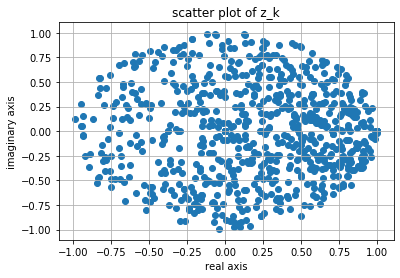

In [141]:
# #np.unique(method.E_array,return_counts=True)[-1]
# #method.z_k[:12]
# E_idx_sorted = np.argsort(method.E_array-method.E_array[0])
# NN = method.E_array[E_idx_sorted[1]]
# NNN = method.E_array[E_idx_sorted[2]]
# print(NN)
# print(NNN)
# print(method.E_array[0])
# diff1 = NN-method.E_array[0]
# diff2 = NNN-method.E_array[0]
# np.nan_to_num(diff1/diff2)
def z_k_spec(val):
        
      
        ##creating an array of the indices of the ratios ascending in magnitude from 
        ##the ith ratio
        E_idx_sorted = np.argsort(np.abs(E_array-val))

        ##takes the first one
        NN = E_array[E_idx_sorted[1]] 
        diff1 = NN-val
        ##takes the second one
        NNN = E_array[E_idx_sorted[2]] 
        diff2 = NNN-val

        ##definition of z_k
        z_k_spec = np.nan_to_num(diff1/diff2)
        
        return z_k_spec
E_array = method.E_array
    
z_k = parallelise_job(z_k_spec,E_array,verbose = False)
z_k
x = np.asarray(z_k).real
y = np.asarray(z_k).imag
plt.scatter(x,y)
plt.grid()
plt.xlabel('real axis')
plt.ylabel('imaginary axis')
plt.title('scatter plot of z_k')
plt.show()

In [117]:
flattened_r_vals = method.r_vals.flatten()
flattened_theta_vals = method.theta_vals.flatten()



print(np.round(flattened_r_vals,2))
print(np.argmin(flattened_r_vals))
print(flattened_r_vals[2080])
np.round(flattened_theta_vals,2)[2080]
# plt.bar(np.round(flattened_r_vals,2),flattened_vals,
# width=0.008,
# align='edge',
# edgecolor='black',
#    color = 'orange')
# plt.xlim(0,1.1)
# plt.xlabel('|z|')
# plt.ylabel('density')
# plt.show()


# plt.bar(np.round(flattened_theta_vals,2),flattened_vals,
# width=0.008,
# align='edge',
# edgecolor='black',
#    color = 'orange')
# #plt.xlim(0,1)
# plt.xlabel('|z|')
# plt.ylabel('density')
# plt.show()


[1.41 1.39 1.37 ... 1.37 1.39 1.41]
2080
0.022447834323382383


0.79

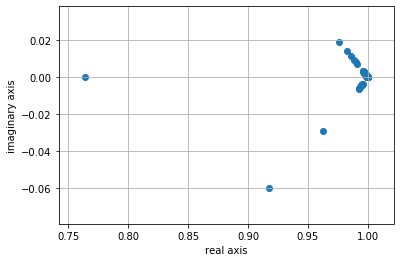

In [59]:
x = np.asarray(method.z_k).real
y = np.asarray(method.z_k).imag
plt.scatter(x,y)
plt.grid()
plt.xlabel('real axis')
plt.ylabel('imaginary axis')
plt.show()

In [165]:
np.shape(method.E_array)

(1024,)

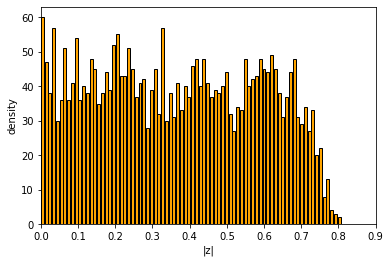

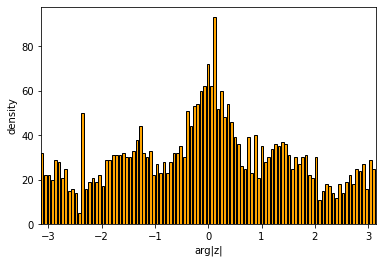

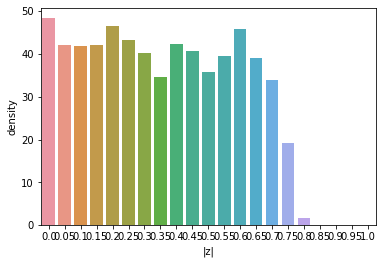

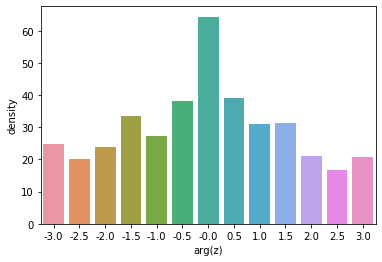

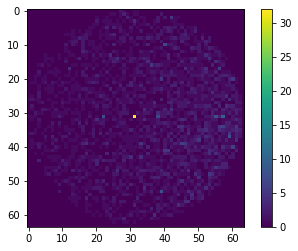

AttributeError: 'lindbladian_Louville_operator' object has no attribute 'imag_vals'

In [38]:
plt.bar(method.r_array,method.r_hists,
width=0.008,
align='edge',
edgecolor='black',
   color = 'orange')
plt.xlim(0,0.9)
plt.xlabel('|z|')
plt.ylabel('density')
#if self.save_boolean:
 #   plt.gcf().tight_layout()
  #  plt.savefig(self.graph_path_r+'.png',dpi=250)
plt.show()

plt.bar(method.theta_array,method.theta_hists,
width=0.05,
align='edge',
edgecolor='black',
   color = 'orange')
plt.xlim(-np.pi,np.pi)
plt.xlabel('arg|z|')
plt.ylabel('density')
# if self.save_boolean:
#     plt.gcf().tight_layout()
#     plt.savefig(self.graph_path_theta+'.png',dpi=250)
plt.show()


r_rounded = (np.round(2*method.r_array,1))/2
theta_rounded = np.round(2*method.theta_array)/2

ax = sns.barplot(x=r_rounded,y=method.r_hists,ci=None)
ax.set(xlabel = '|z|',ylabel = 'density')
plt.show()

ax = sns.barplot(x=theta_rounded,y=method.theta_hists,ci=None)
ax.set(xlabel = 'arg(z)',ylabel = 'density')
plt.show()

##plots heatmap
plt.imshow(method.heatmap_vals)
plt.colorbar()
plt.show()


##plotting a seaborn heatnap
df = pd.DataFrame(data=method.heatmap_vals,index = np.round(-method.imag_vals,1), columns=np.round(method.real_vals,1))
sns.heatmap(df)
plt.xlabel('real axis')
plt.ylabel('imaginary axis')
# if self.save_boolean:
#     plt.gcf().tight_layout()

#     plt.savefig(self.heatmap_path+'.png',dpi=250)

plt.show()


In [15]:
import multiprocessing as mp
E_array = method.E_array_no_deg



def parallelise_job(function,inputs,verbose = 1,backend = 'loky',n_jobs = -1):
    """
    Performs a parallelised task using joblib (which works in notebooks).
    """
    return Parallel(n_jobs=n_jobs, verbose=verbose,backend = backend)(
                 map(delayed(function), inputs))


def z_k_spec(value):
        
        
        ##removes degeneracy
        E_array_no_deg = np.unique(E_array)
        ##saves the degeneracy factors of all the energies
                
        ##creating an array of the indices of the ratios ascending in magnitude from 
        ##the ith ratio
        E_idx_sorted = np.argsort(np.abs(E_array_no_deg-value))

        ##takes the first one
        NN = E_array_no_deg[E_idx_sorted[1]] 
        diff1 = NN-value
        ##takes the second one
        NNN = E_array_no_deg[E_idx_sorted[2]] 
        diff2 = NNN-value

        ##definition of z_k
        z_k_spec = diff1/diff2
        
        return z_k_spec

y = parallelise_job(z_k_spec,E_array,verbose = 1)
y

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1024 out of 1024 | elapsed:    0.9s finished


[(0.1662154958779706-3.8859064611529564e-16j),
 (-0.19935066561712445+5.589651136077699e-16j),
 (0.22457785380872233+1.679536620528495e-15j),
 (-0.2896201184242737-2.793271028049246e-15j),
 (0.7754221461912776-1.679536620528495e-15j),
 (0.996815663197452-0.07974041387038074j),
 (0.2449209863640518+0.04432420005223913j),
 (0.24492098636398454-0.04432420005226889j),
 (-0.31981681391012495+0.07747510318211578j),
 (-0.31981681391024785-0.07747510318207791j),
 (0.7550790136359482-0.044324200052239145j),
 (0.7550790136360155+0.044324200052268864j),
 (0.05662880094257844+0.33173902512207765j),
 (0.056628800942563125-0.3317390251220831j),
 (0.07513578482911633-0.030594219627170453j),
 (0.0751357848291017+0.030594219627165107j),
 (-0.08005793063332886-0.03572797930532069j),
 (-0.0800579306333455+0.035727979305328054j),
 (0.9433711990574215-0.33173902512207765j),
 (0.8649499979610353-0.26893065163171065j),
 (-0.9467270932031238+0.3220369714722206j),
 (0.49999999999997896-0.08271240807111745j),
 

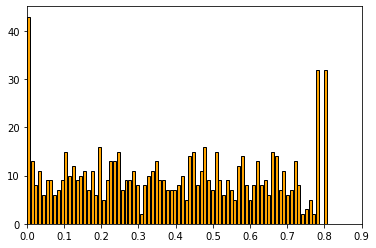

In [47]:
plt.bar(method.r_array,method.r_hists,
        width=0.008,
        align='edge',
        edgecolor='black',
       color = 'orange')
plt.xlim(0,0.9)
plt.show()

In [22]:
np.load(method.z_k_path+'N=' + str(method.N) +' , b=' +str(method.b)+', non H XXX average'+'.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'C://Users/david/OneDrive/Documents/UNI/UCL project/data/z_k raw data/non H XXX/N=5 , b=0, non H XXX average.npy'

In [24]:
range(1,10)[5]


6

In [40]:
def averaging_data(model_choice,N):
    if 
    if self.N = 5:
        
    if self.N = 6:

        
    np.load(method.z_k_path+'.npy')


array([-1.70660060e-04+4.47265512e-02j, -1.70660060e-04-4.47265512e-02j,
        9.50270828e-01+2.17028489e-01j, ...,
        9.14724955e-01-8.37703229e-15j, -8.61533109e-01+1.68213228e-14j,
        5.37191627e-01+4.85421061e-15j])

In [32]:
(np.round(2*method.r_array,1))/2

array([0.  , 0.  , 0.  , 0.05, 0.05, 0.05, 0.05, 0.05, 0.1 , 0.1 , 0.1 ,
       0.1 , 0.1 , 0.15, 0.15, 0.15, 0.15, 0.15, 0.2 , 0.2 , 0.2 , 0.2 ,
       0.2 , 0.25, 0.25, 0.25, 0.25, 0.25, 0.3 , 0.3 , 0.3 , 0.3 , 0.3 ,
       0.35, 0.35, 0.35, 0.35, 0.35, 0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.45,
       0.45, 0.45, 0.45, 0.45, 0.5 , 0.5 , 0.5 , 0.5 , 0.55, 0.55, 0.55,
       0.55, 0.55, 0.6 , 0.6 , 0.6 , 0.6 , 0.6 , 0.65, 0.65, 0.65, 0.65,
       0.65, 0.7 , 0.7 , 0.7 , 0.7 , 0.7 , 0.75, 0.75, 0.75, 0.75, 0.75,
       0.8 , 0.8 , 0.8 , 0.8 , 0.8 , 0.85, 0.85, 0.85, 0.85, 0.85, 0.9 ,
       0.9 , 0.9 , 0.9 , 0.9 , 0.95, 0.95, 0.95, 0.95, 0.95, 1.  , 1.  ,
       1.  ])

In [29]:
np.load()

array([ 16,  16,  12,  12,  56,  56,   8,   8,  12,  12,   8,   8,  16,
        16,   8,   8,   8,   8,  56,  56,  56,  56,  56,  56,  56,  56,
        32,   1,   1,  38,   2,   2, 140,   1,   1,  38,  32], dtype=int64)

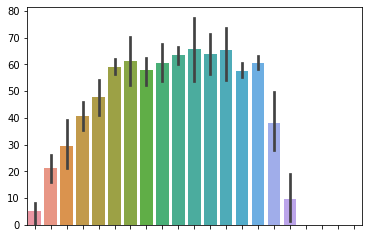

In [36]:
ax = sns.barplot(x=(np.round(2*method.r_array,1))/2,y=method.r_hists)
ax.set(xticklabels=[])
plt.show()

In [21]:
np.random.RandomState(100)
arr = np.random.randint(0, 10, size=[200000, 5])
data = arr.tolist()
data[:5]



[[8, 0, 6, 9, 7],
 [4, 9, 4, 7, 0],
 [0, 6, 6, 2, 5],
 [9, 2, 3, 9, 6],
 [9, 1, 8, 0, 3]]

AttributeError: 'numpy.ndarray' object has no attribute 'get'

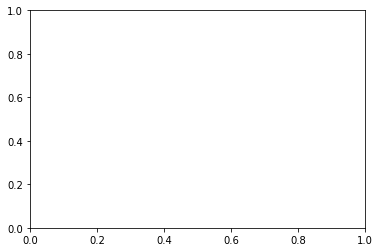

In [53]:


df = pd.DataFrame()


sns.barplot(x='method.r_array',y='method.r_hists',data=method.r_hists,ax=ax)
ax.set(xlabel = '|z|',
              ylabel = 'density',
              xticklabels=[])
ax.set_xlim(0,100)
plt.show()
# ax = sns.barplot(x=method.theta_array,y=method.theta_hists)
# ax.set(xlabel = 'arg(z)',
#               ylabel = 'density',
#               xticklabels=[])
# plt.show()
        

In [52]:
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.barplot(x="day", y="total_bill", data=tips)

AttributeError: module 'seaborn' has no attribute 'set_theme'

In [95]:


###works up up to the limit**2 for precision (limit of the while loop)
def my_expm(A):
    ####reduces precision
    A = np.asarray(A)
    
    m,n = np.shape(A)
    k = 0
    fact = 1
    matpow = np.eye(n)
    expmat = np.matrix(np.zeros([n,n]))
    lastnorm = 1
    while lastnorm > 1e-4:
        expmat = expmat + matpow/fact
        lastnorm = np.max(abs(matpow/fact))
        k += 1
        if k ==170: ##computer can't handle factors when they're this large
            break
        fact *= k
        matpow = A@matpow
        if k%10 ==0:
            print(k)
    return expmat


#do diagonalisation method for expA
def my_expm2(A):
    m,n = np.shape(A)
    evecs = A.eigenstates()[1]
    evals = A.eigenstates()[0]
    diag_A = np.diag(evals)
    D = np.zeros(np.shape(A),dtype=np.csingle)
    for i in range(n):
        D[:,i] = np.asarray(evecs[i]).reshape(n)
    D = Qobj(D)
    D_inv = D.inv()
    k = 0
    fact = 1
    matpow = np.eye(n)
    expmat = np.matrix(np.zeros([n,n]))
    lastnorm = 1
    while lastnorm > 1e-4:
        expmat = expmat + matpow/fact
        lastnorm = np.max(abs(matpow/fact))
        k += 1
        fact *= k
        matpow = matpow*diag_A
    expmat = Qobj(expmat)
    expmat = D*(expmat*D_inv)

    return expmat

In [ ]:
x = csc_matrix(np.asarray(method.L))

def my_expm3(A): ###using gensim
    m,n = np.shape(A)
    evecs = A.eigenstates()[1]
    evals = A.eigenstates()[0]
    diag_A = np.diag(evals)
    D = np.zeros(np.shape(A),dtype=np.csingle)
    for i in range(n):
        D[:,i] = np.asarray(evecs[i]).reshape(n)
    D = Qobj(D)
    D_inv = D.inv()
    k = 0
    fact = 1
    matpow = np.eye(n)
    expmat = np.matrix(np.zeros([n,n]))
    lastnorm = 1
    while lastnorm > 1e-4:
        expmat = expmat + matpow/fact
        lastnorm = np.max(abs(matpow/fact))
        k += 1
        fact *= k
        matpow = matpow*diag_A
    expmat = Qobj(expmat)
    expmat = D*(expmat*D_inv)

    return expmat  

In [12]:
x = csc_matrix(np.asarray(method.L))

In [5]:
x = sp.sparse.random(1600,1600,density=0.1)
x = x.tocsc()

NameError: name 'sp' is not defined

In [9]:
import gensim
from gensim.test.utils import common_dictionary, common_corpus
import gensim.models
from gensim.models import LsiModel


In [25]:
U,s = gensim.models.lsimodel.stochastic_svd(np.abs(x), 
                                      rank=4096,
                                      num_terms = 4096,
                                      chunksize=100,)

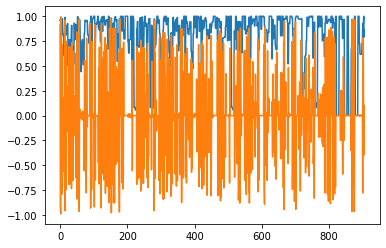

In [99]:
coords = np.asarray(range(906))
plt.plot(coords,np.abs(method.z_k))
plt.plot(coords,method.z_k.imag)
plt.show()

In [46]:
x = np.asarray((5000j,3,3,3,5,2,8,7,6,6),dtype=np.complex128)
np.unique(x)

array([0.+5000.j, 2.   +0.j, 3.   +0.j, 5.   +0.j, 6.   +0.j, 7.   +0.j,
       8.   +0.j])

In [ ]:
       
        
        #         trig1 = True
#         k=0
        
        
#         while trig1:
#         #for i in tqdm_notebook(range(np.size(E_array)),leave=False):
            
#             ##This parameter gives the degeneracy of the kth group of eigenenergies.
#             z_k_deg_k = 1
#             ##This parameter gives the degeneracy of the nearest neighbour of the kth group of eigenenergies,
#             ##where 'group' means a subset of equal eigenenergies.
#             z_k_degNN = 1
            
            
#             ###creating an array of the indices of the ratios ascending in magnitude from 
#             ##the ith ratio
#             E_idx_sorted = np.argsort(np.abs(E_array-E_array[k]))
            
#             ##The following while loop assigns the nearest and next nearest neighbours for 
#             ##the kth value of E_array, and if any difference is zero (degeneracies) the loop 
#             ##keeps moving until a non degenerate value is found
#             trig2 = True
#             i=1
#             n=1
#             while trig2:
#                 ##takes the first one (and then kth one if there are degeneracies)
#                 NN = E_array[E_idx_sorted[i]] 
                
#                 ##boolean for whether NN is degenerate with E_array[k]
#                 bool_NN = (NN!=E_array[k])
#                 if bool_NN:
#                     NNN = E_array[E_idx_sorted[i+n]] ##takes the second one
#                     bool_NNN = (NNN!=NN)
#                     if bool_NNN:
#                         E_array_updated = 
#                         trig2 = False
#                     n += 1
#                     z_k_degNN += 1
#                 i += 1
#                 z_k_deg_k += 1
                
#                 ###IM OVERCOUNTING DEGENERACIES
                
#             ##definition of z_k
            
#             z_k.append((NN-E_array[i])/(NNN-E_array[i]))
            
#             ##z_k_deg_k only matters for k==0, for k>0 the code has already considered the degeneracy of
#             ##E_array[k] via z_k_degNN in the previous iteration.
#             if k==0: 
#                 z_k_deg.append(z_k_deg_k)
#                 k += z_k_deg_k
            
#             z_k_deg.append(z_k_degNN)
#             k += z_k_degNN
            
            
            
            ##THIS IS WRONG AS E_array ISNT ORDERED INITIALLY
            
            
            
            
            ##This for loop stops the while loop when all of the E_array elements have been evaluated
            if k == np.size(E_array):
                trig1 = False 
        
        
        
            
#         for i in range(self.NH-1):
#             ##summing up array of truths and falses where the r value 
#             ##falls in r_array[i]<r<r_array[i+1]
#             radial_bool = (r_vals>=r_array[i])*(r_vals<=r_array[i+1])
#             R_Hists[i] = np.sum(heatmap_vals*radial_bool)
        
#         for j in range(self.NH-1):
#                 ##same for theta
#                 theta_bool = (theta_vals>=theta_array[i])*(theta_vals<=theta_array[i+1])
#                 Theta_Hists[j] = np.sum(heatmap_vals*theta_bool)
        